In [243]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
import datetime as dt
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines
from urllib.request import urlopen
from bs4 import BeautifulSoup
from functools import reduce
from collections import OrderedDict
from datetime import date
import datetime
# new
from datetime import datetime


In [98]:
## set wmdr xml file location
record_file = "/home/sdanioth/Documents/git/OSCAR_analysis/Files/file.xml"
id = "0-404-300-160800395AS00001"
url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id

response = requests.get(url)
soup= BeautifulSoup(response.content,"xml")

with open(record_file, 'w') as f:
    f.write(soup.prettify())

tree = ET.parse(record_file)
root = tree.getroot()

# namespaces
ns = {
    "gml": "http://www.opengis.net/gml/3.2",
    "xlink": "http://www.w3.org/1999/xlink",
    "wmdr": "http://def.wmo.int/wmdr/2017",
    "gco": "http://www.isotc211.org/2005/gco",
    "gmd": "http://www.isotc211.org/2005/gmd",
    "ns6": "http://def.wmo.int/opm/2013",
    "ns7": "http://def.wmo.int/metce/2013",
    "om": "http://www.opengis.net/om/2.0",
    "ns9": "http://www.isotc211.org/2005/gts",
    "sam": "http://www.opengis.net/sampling/2.0",
    "sams": "http://www.opengis.net/samplingSpatial/2.0",
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}
results = list()
capabilities = root.findall(".//wmdr:ObservingCapability", ns)
for capability in capabilities:
    observations = capability.findall(".//wmdr:observation", ns)
    for observation in observations:
        # find observed property
        observedProperty = observation.find(".//om:OM_Observation/om:observedProperty", ns).attrib["{http://www.w3.org/1999/xlink}href"]
        # get notation of observed property
        observedProperty_notation = int(observedProperty.split('/')[-1])
        print(observedProperty_notation)
        # find beginning of deployment
        beginPosition = observation.find(".//om:OM_Observation/om:procedure/wmdr:Process/wmdr:deployment/wmdr:Deployment/wmdr:validPeriod/gml:TimePeriod/gml:beginPosition", ns).text
        # find potential ending of deployment
        endPosition = observation.find(".//om:OM_Observation/om:procedure/wmdr:Process/wmdr:deployment/wmdr:Deployment/wmdr:validPeriod/gml:TimePeriod/gml:endPosition", ns).text
    
        results.append({
            "observedProperty": observedProperty,
            "beginPosition": beginPosition,
            "endPosition": endPosition
        })

results
# df_results = pd.DataFrame(results)
# df_results


192
194
251
210
216
224
12005
12006
527


[{'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVariableAtmosphere/192',
  'beginPosition': '\n                  2022-09-25T00:00:00Z\n                 ',
  'endPosition': None},
 {'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVariableAtmosphere/194',
  'beginPosition': '\n                  2022-09-25T00:00:00Z\n                 ',
  'endPosition': None},
 {'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVariableAtmosphere/251',
  'beginPosition': '\n                  2022-09-25T00:00:00Z\n                 ',
  'endPosition': None},
 {'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVariableAtmosphere/210',
  'beginPosition': '\n                  2022-09-25T00:00:00Z\n                 ',
  'endPosition': None},
 {'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVariableAtmosphere/216',
  'beginPosition': '\n                  2022-09-25T00:00:00Z\n                 ',
  'endPosition': None},
 {'observedProperty': 'http://codes.wmo.int/wmdr/ObservedVar

In [99]:
### test ####

In [100]:
# define function: get all WIGOS identifier

def get_WIGOS_ID_country(country):

    """ use the OSCAR API to find all stations registered within one country

        Parameters:
        country (str): country code - e.g. KEN for Kenya

        Returns:
        wigosIds (list): list of all WIGOS IDs of registered stations in selected country
    """

    # open API
    all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName=" + country
    response = urlopen(all_stations_KEN_url)
    data_json = json.loads(response.read())

    # find WIGOS IDs and save in list
    wigosIds = []
    for station in data_json["stationSearchResults"]:
        wigosId = str(station["wigosId"])
        wigosIds.append(wigosId)

    return wigosIds

In [213]:
#### new ####

# define function: save basic information to json file

def save_basic_info_to_json(country):

    """create json file with information on WIGOS ID, Name, latitude, longitude, elevation, facility Type, observed Properties,
       date Established, date Closed & reportingStatus of all stations within selected country

        Parameters:
        country (str): country code - e.g. "KEN" for Kenya
    """

    # create empty json file to add station data from xml files to
    j_data = '{"stations":[]}'
    file = open("stations.json", "w")
    file.write(j_data)
    file.close()

    # get list of WIGOS identifiers of country of interest
    wigosIds = get_WIGOS_ID_country(country)

    # name spaces
    ns = {
        "gml": "http://www.opengis.net/gml/3.2",
        "xlink": "http://www.w3.org/1999/xlink",
        "wmdr": "http://def.wmo.int/wmdr/2017",
        "gco": "http://www.isotc211.org/2005/gco",
        "gmd": "http://www.isotc211.org/2005/gmd",
        "ns6": "http://def.wmo.int/opm/2013",
        "ns7": "http://def.wmo.int/metce/2013",
        "om": "http://www.opengis.net/om/2.0",
        "ns9": "http://www.isotc211.org/2005/gts",
        "sam": "http://www.opengis.net/sampling/2.0",
        "sams": "http://www.opengis.net/samplingSpatial/2.0",
        "xsi": "http://www.w3.org/2001/XMLSchema-instance"
    }

    # Get station xml Files via jOAI and save relevant information in json file
    for id in wigosIds:
        
        ## set wmdr xml file location
        record_file = "/home/sdanioth/Documents/git/OSCAR_analysis/Files/file.xml"
        # open xml
        url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
        response = requests.get(url)
        soup= BeautifulSoup(response.content,"xml")
        with open(record_file, 'w') as f:
            f.write(soup.prettify())

        tree = ET.parse(record_file)
        root = tree.getroot()


        # get information from OAI
        metadata = root.find('.//wmdr:WIGOSMetadataRecord',ns) #check if xml file is available on jOAI
        if metadata:
            # Name
            name = root.find(".//wmdr:facility/wmdr:ObservingFacility/gml:name", ns).text
            name = name.strip()

            # Location
            location = root.find(".//wmdr:facility/wmdr:ObservingFacility/wmdr:geospatialLocation/wmdr:GeospatialLocation/wmdr:geoLocation/gml:Point/gml:pos", ns).text
            split_values = location.split()
            numbers = [float(value) for value in split_values]
            lat = numbers[0]
            lon = numbers[1]
            if len(numbers) == 3:
                ele = numbers[2]
            else:
                ele = "unknown"
            
            # facility type
            facilityType = root.find(".//wmdr:facility/wmdr:ObservingFacility/wmdr:facilityType", ns).attrib["{http://www.w3.org/1999/xlink}href"]
            facilityType = facilityType.split('/')[-1]
            
            # observed Variables
            variables = list()
            capabilities = root.findall(".//wmdr:ObservingCapability", ns)
            for capability in capabilities:
                observations = capability.findall(".//wmdr:observation", ns)
                for observation in observations:
                    # find observed property
                    observedProperty = observation.find(".//om:OM_Observation/om:observedProperty", ns).attrib["{http://www.w3.org/1999/xlink}href"]
                    # get notation of observed property
                    variables.append(int(observedProperty.split('/')[-1]))
            
            # Date established
            dateEstablished = root.find(".//wmdr:facility/wmdr:ObservingFacility/wmdr:dateEstablished", ns).text
            if dateEstablished:
                 dateEstablished = dateEstablished.strip()
            else:
                dateEstablished = np.nan

            # Date closed
            dateClosed = root.findall(".//wmdr:facility/wmdr:ObservingFacility/wmdr:dateClosed", ns)
            if dateClosed:
                dateClosed = dateClosed[0].text.strip()
            else:
                dateClosed = np.nan

            # ReportingStatus
            reportingStatus = root.findall(".//wmdr:facility/wmdr:ObservingFacility/wmdr:programAffiliation/wmdr:ProgramAffiliation/wmdr:reportingStatus/wmdr:ReportingStatus/wmdr:reportingStatus", ns)
            if reportingStatus:
                reportingStatus = reportingStatus[0].attrib["{http://www.w3.org/1999/xlink}href"]
                reportingStatus = reportingStatus.split('/')[-1]
            else: 
                reportingStatus = "unknown"
            
            # save information to json File
            aDict = {"wigosId" : id, "name":name, "lat":lat, "lon":lon, "ele":ele, "facilityType":facilityType, "observedProperties" : variables, "dateEstablished" : dateEstablished, "dateClosed" : dateClosed, "reportingStatus" : reportingStatus}
            # print(aDict)
            write_json(aDict)


In [214]:
save_basic_info_to_json(country="KEN")

In [246]:
def plot_maps_establishment_decade(json_file, reporting = True):

    """ create plot showing maps (one for every decade) with all catalogued stations established within that decade

        Parameters:
        json_file (.json file): containing the required information on the stations
        (WIGOS ID, name, lat, lon, elevation, facilityType, observed Properties, dateEstablsihed,
        dateClosed & reportingStatus)
        reporting (boolean): True -> color of dots according to reporting status, False -> all dots the same color
    """

    # create plot
    plt.style.use('default')
    fig, axes = plt.subplots(2,4, figsize=(16,9.7))
    axes = axes.ravel()

    # load data
    f = open(json_file)
    data = json.load(f)

    # years
    years = [1961, 1961, 1971, 1981, 1991, 2001, 2011, 2021, 2031]

    # loop over decades; for every decade one map showing the stations established within
    for i, decade in enumerate(["before 1961", "1961 - 1970", "1971 - 1980", "1981 - 1990", "1991 - 2000", "2001 - 2010", "2011 - 2020", "since 2021"]):

        # map background
        m = Basemap(projection='lcc', resolution='l', lat_0=0.1, lon_0=37.5, width=1.5E6, height=1.2E6,  ax = axes[i])
        m.drawcoastlines(color='grey', linewidth=0.8)
        m.drawcountries(color='black', linewidth=2)

        # find stations established within decade
        df = pd.DataFrame(data["stations"])
        df['dateEstablished'] = pd.to_datetime(df['dateEstablished'], format='%Y-%m-%dZ')

        if i == 0:
            df = df[(df["dateEstablished"] < pd.to_datetime(datetime(1961, 1,1)))]
        else:
            df = df[(df["dateEstablished"] >= pd.to_datetime(datetime(years[i], 1,1))) & (df["dateEstablished"] < pd.to_datetime(datetime(years[i+1], 1,1)))]

        # plot dots for established stations
        if not df.empty:
            lat = df["lat"]
            lon = df["lon"]
            if reporting == True:
                colors = {'operational':'tab:blue', 'preOperational':'tab:purple', 'unknown':'tab:grey', 'closed':'tab:red', 'nonReporting':'tab:orange'}
                m.scatter(lon, lat, latlon=True, c=df["reportingStatus"].map(colors),s=60,marker="*")
            else:
                m.scatter(lon, lat, latlon=True, c="blue",s=30,marker="*")

        # small title over every map
        axes[i].set_title(decade)

    # large title
    plt.suptitle('Establishment of stations', fontsize=20, fontweight="bold")

    # handles, labels = axes.get_legend_handles_labels()
    if reporting == True:
        stations = [mlines.Line2D([0], [0], color="w", marker='*',markersize=20,  markerfacecolor=v, label=k) for k, v in colors.items()]
        fig.legend(handles=stations, loc='lower center', ncol=len(stations), title="Today's reporting status", title_fontproperties={'weight':'bold'})
    plt.tight_layout(pad=1)

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save plot
    if reporting == True:
        plt.savefig(dir+"/Map_establishment_decade_reporting_"+str(date_today)+"_.jpeg", bbox_inches='tight')
    else:
        plt.savefig(dir+"/Map_establishment_decade_reportingStatus_"+str(date_today)+"_.jpeg", bbox_inches='tight')


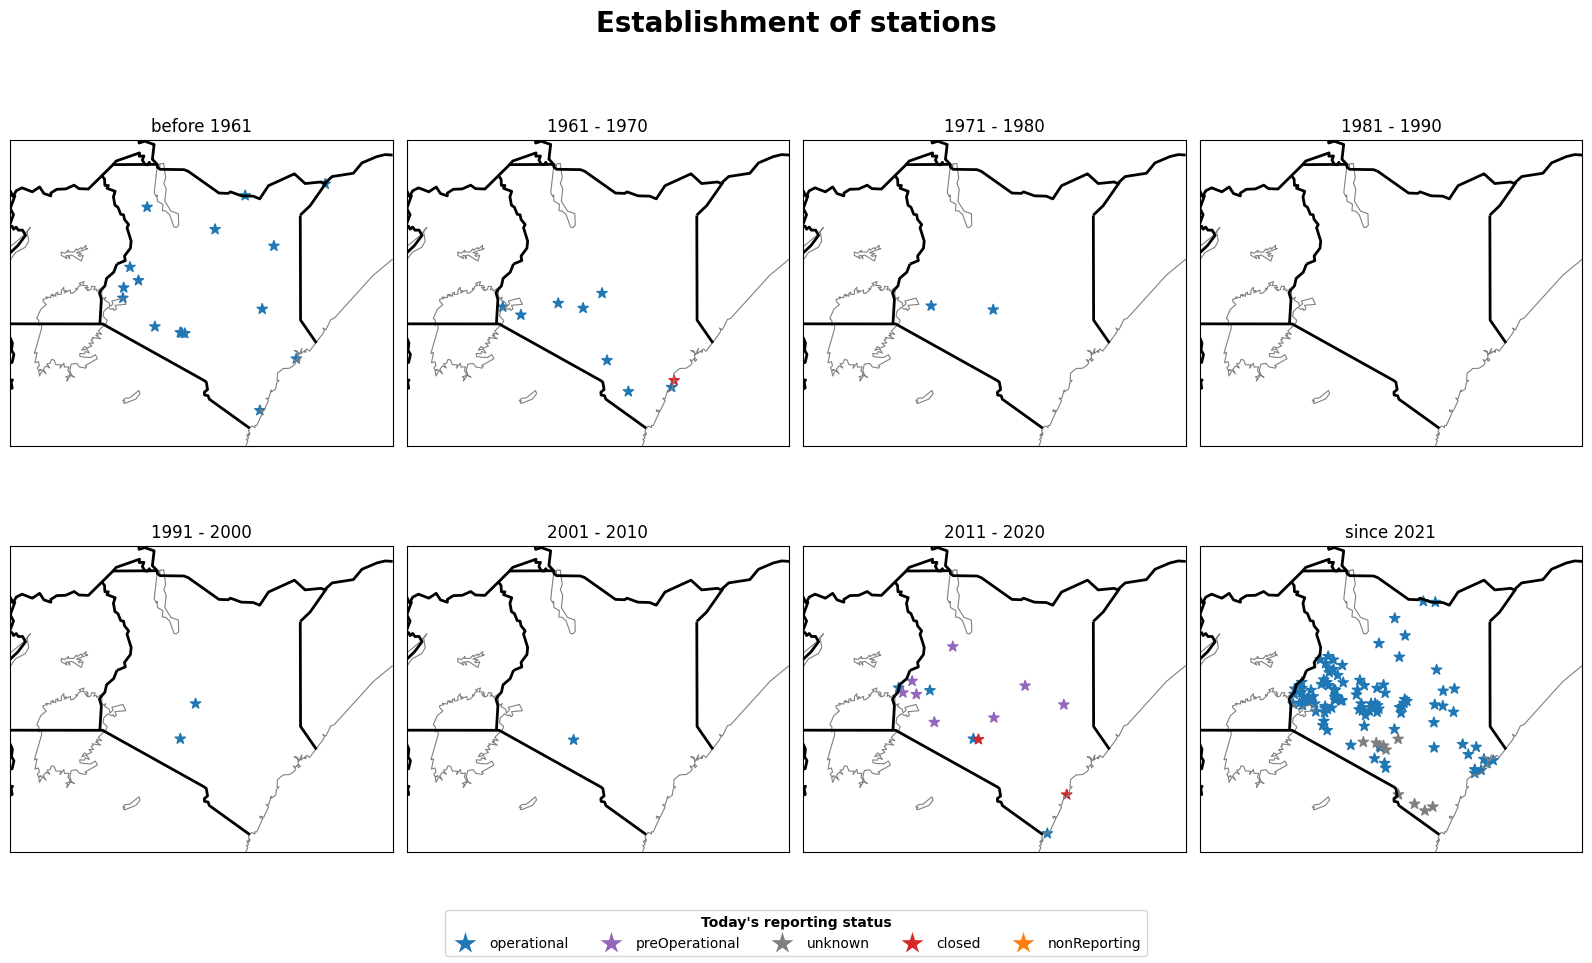

In [247]:
plot_maps_establishment_decade(json_file="/home/sdanioth/Documents/git/OSCAR_analysis/sandbox/stations.json")

In [102]:
#### can be deleted ###

# define function: get xml files

def get_xml_info(WIGOS_ID):

    """get xml information through jOAI and save file

        Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest
    """
    id = WIGOS_ID
    # open xml file through jOAI
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')
    content = soup('OAI-PMH')

    # save file
    with open("/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_"+id+".txt", 'w') as f:
        f.write(str(content))


In [206]:
# define function: append information to json file

def write_json(new_data, filename='stations.json'):

    """ create a json file and add information on stations to it

        Parameters:
        new_data (dictionary): dictionary including {"wigosId" : id, "name":name, "lat":lat,
        "lon":lon, "ele":ele, "facilityType":facilityType, "observedProperties" : observedProperties_notation,
        "dateEstablished" : dateEstablished, "dateClosed" : dateClosed, "reportingStatus" : reportingStatus}
        filename (str): name of json file

    """

    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["stations"].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [106]:
#### new ####


def get_deployments_station(WIGOS_ID):

    """ create data frame with the required information (station, establishment date and deployment dates) of a specific station

        Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest

        Returns:
        df_station (data frame): data frame with the required information (start and end dates of deployments, establishment date, etc.)
    """

    ## set wmdr xml file location
    record_file = "/home/sdanioth/Documents/git/OSCAR_analysis/Files/file.xml"
    WIGOS_ID = "0-20008-0-MKN"
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + WIGOS_ID

    response = requests.get(url)
    soup= BeautifulSoup(response.content,"xml")

    with open(record_file, 'w') as f:
        f.write(soup.prettify())

    tree = ET.parse(record_file)
    root = tree.getroot()

    # namespaces
    ns = {
        "gml": "http://www.opengis.net/gml/3.2",
        "xlink": "http://www.w3.org/1999/xlink",
        "wmdr": "http://def.wmo.int/wmdr/2017",
        "gco": "http://www.isotc211.org/2005/gco",
        "gmd": "http://www.isotc211.org/2005/gmd",
        "ns6": "http://def.wmo.int/opm/2013",
        "ns7": "http://def.wmo.int/metce/2013",
        "om": "http://www.opengis.net/om/2.0",
        "ns9": "http://www.isotc211.org/2005/gts",
        "sam": "http://www.opengis.net/sampling/2.0",
        "sams": "http://www.opengis.net/samplingSpatial/2.0",
        "xsi": "http://www.w3.org/2001/XMLSchema-instance"
    }


    # date of establishment
    dateEstablished = root.find(".//wmdr:facility/wmdr:ObservingFacility/wmdr:dateEstablished", ns).text
    if dateEstablished:
        dateEstablished = datetime.strptime(dateEstablished.strip(), '%Y-%m-%dZ')
    else:
        dateEstablished = "unknown"

    results = list()

    # find observing capabilities in xml file
    capabilities = root.findall(".//wmdr:ObservingCapability", ns)
    for capability in capabilities:
        observations = capability.findall(".//wmdr:observation", ns)
        for observation in observations:
            # find observed property
            observedProperty = observation.find(".//om:OM_Observation/om:observedProperty", ns).attrib["{http://www.w3.org/1999/xlink}href"]
            # get notation of observed property
            observedProperty_notation = int(observedProperty.split('/')[-1])

            # find beginning of deployment
            beginPosition = observation.find(".//om:OM_Observation/om:procedure/wmdr:Process/wmdr:deployment/wmdr:Deployment/wmdr:validPeriod/gml:TimePeriod/gml:beginPosition", ns).text
            if beginPosition:
                beginPosition = pd.to_datetime(beginPosition.strip(), format='%Y-%m-%dT%H:%M:%SZ')
            else:
                beginPosition = np.nan
            
            # find potential ending of deployment
            endPosition = observation.find(".//om:OM_Observation/om:procedure/wmdr:Process/wmdr:deployment/wmdr:Deployment/wmdr:validPeriod/gml:TimePeriod/gml:endPosition", ns).text
            if endPosition:
                endPosition = pd.to_datetime(endPosition.strip(), format='%Y-%m-%dT%H:%M:%SZ')
            else: # if no ending: today
                endPosition = pd.Timestamp.today().strftime("%Y-%m-%d")

            results.append({
                "variable": observedProperty_notation,
                "beginPosition": beginPosition,
                "endPosition": endPosition
            })

    # create data frame
    df_station = pd.DataFrame(results)

    # get names of variables through dictionary
    with open("/home/sdanioth/Documents/git/OSCAR_analysis"+'/WMDR_dictionaries/'+'T_GO_VARIABLE_REF_dictionary.json') as f:
        dictionary = json.loads(f.read())
        variables = df_station["variable"]
        df_station["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]

    df_station["station"] = WIGOS_ID
    df_station["dateEstablished"] = dateEstablished

    variables_u = df_station["variable"].unique().tolist()
    

    return df_station, variables_u

In [293]:
# define function: create plot showing all deployments registered for a specific station

def plot_deployments_station(WIGOS_ID, include_establishmentDate = False, show=False):

    """ create plot showing all deployments registered for a specific station

        Parameters:
        WIGOS_ID (str): WIGOS identifier of the station of interest
        include_establishmentDate (boolean): if True - vertical red line indicates establishment date
        show (boolean): whether plot should be shown (default: show=False - plot is saved without being shown)
    """

    id = WIGOS_ID
    # from get_information import get_deployments_station
    df_station,variables_u = get_deployments_station(id)

    # plot
    plt.style.use('default')
    fig, axes = plt.subplots(1,1, figsize=(14,8))
    variables = variables_u

    df_station['beginPosition'] = pd.to_datetime(df_station['beginPosition'])
    
    # plot every deployment
    for var in range(0,len(variables)):
        df_var = df_station[df_station["variable"]==variables[var]]
        x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
        plt.plot(x_values, [var,var], 'bo', linestyle="--")

    # line for establishment date
    if include_establishmentDate == True:
        est_date = [pd.to_datetime(df_station["dateEstablished"].iloc[0])]
        plt.axvline(x=est_date, c="red", linewidth=5, label= "Establishment Date")
        # legend
        plt.legend(loc="upper left", fontsize=10, scatterpoints=25, bbox_to_anchor=(-0.2, 1.06))

    # plot ployment names
    names = []
    for var in range(0,len(variables)):
        variable_df = df_station[df_station["variable"]==variables[var]]
        name = variable_df.iloc[0]["variables_names"]
        names.append(name)
    n = range(0,len(names))
    plt.yticks(n,names)

    # title
    plt.title("WIGOS Station Identifier: " + id, fontsize=16, fontweight="bold")



    if show == True:
        plt.show()
    else:
        plt.close()

[0   1999-01-01
Name: beginPosition, dtype: datetime64[ns], 0   2023-12-13
Name: endPosition, dtype: datetime64[ns]]
[1   2003-12-01
Name: beginPosition, dtype: datetime64[ns], 1   2011-06-21
Name: endPosition, dtype: datetime64[ns]]
[2   2003-12-01
Name: beginPosition, dtype: datetime64[ns], 2   2011-06-21
Name: endPosition, dtype: datetime64[ns]]
[3   2003-12-01
Name: beginPosition, dtype: datetime64[ns], 3   2011-06-21
Name: endPosition, dtype: datetime64[ns]]
[4   2003-12-01
Name: beginPosition, dtype: datetime64[ns], 4   2011-06-21
Name: endPosition, dtype: datetime64[ns]]
[5   1999-01-01
Name: beginPosition, dtype: datetime64[ns], 5   2023-12-13
Name: endPosition, dtype: datetime64[ns]]
[6   1999-01-01
Name: beginPosition, dtype: datetime64[ns], 6   2023-12-13
Name: endPosition, dtype: datetime64[ns]]
[7   1999-01-01
Name: beginPosition, dtype: datetime64[ns], 7   2023-12-13
Name: endPosition, dtype: datetime64[ns]]
[8   1999-01-01
Name: beginPosition, dtype: datetime64[ns], 8   

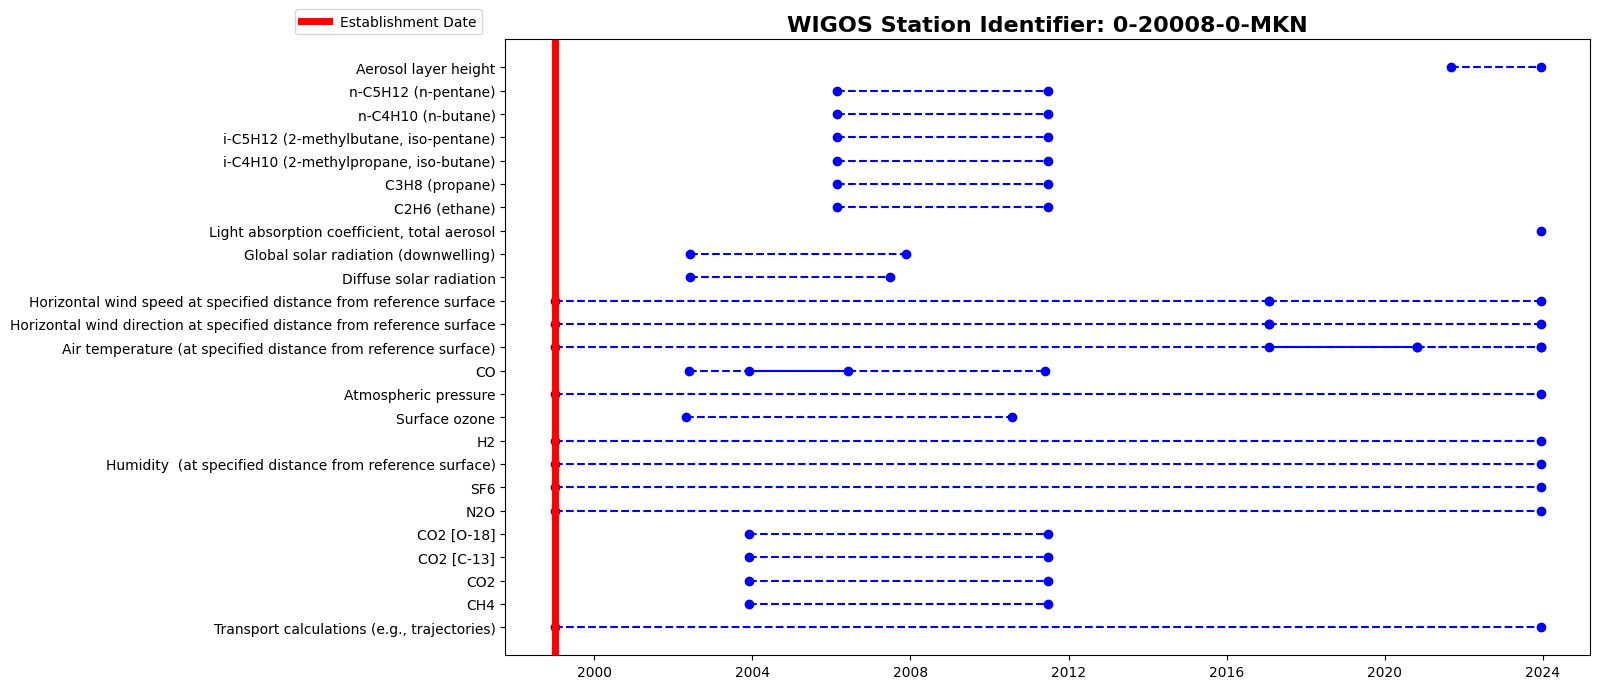

In [294]:
plot_deployments_station(WIGOS_ID="0-20008-0-MKN", include_establishmentDate = True, show=True)

In [107]:
# choose the station (WIGOS ID)
id = '0-20008-0-MKN' # Mount Kenya as example

get_deployments_station(WIGOS_ID=id)


(    variable beginPosition          endPosition  \
 0        248    1999-01-01           2023-12-13   
 1        192    2003-12-01  2011-06-21 00:00:00   
 2        194    2003-12-01  2011-06-21 00:00:00   
 3        195    2003-12-01  2011-06-21 00:00:00   
 4        196    2003-12-01  2011-06-21 00:00:00   
 5        201    1999-01-01           2023-12-13   
 6        203    1999-01-01           2023-12-13   
 7        251    1999-01-01           2023-12-13   
 8        205    1999-01-01           2023-12-13   
 9        262    2002-05-01  2010-08-01 00:00:00   
 10       216    1999-01-01           2023-12-13   
 11       284    2003-12-01  2011-05-31 00:00:00   
 12       284    2002-05-31  2006-05-31 00:00:00   
 13       224    2020-10-28           2023-12-13   
 14       224    2017-01-26  2020-10-27 00:00:00   
 15       224    1999-01-01           2023-12-13   
 16     12005    2017-01-26           2023-12-13   
 17     12005    1999-01-01  2017-01-25 00:00:00   
 18     1200